# 미니 경진대회 - 선박 도장 품질 분류

본 파일은 경연대회에 참가하시는 모든 참가자 분들에게 제공되는 기본 코드입니다. 따라서 **본인이 원하는 대로 자유롭게 수정하면서 경진대회를 진행하세요.** 

본 코드는 플랫폼 상에서 데이터를 불러오는 방법부터 간단한 전처리 및 머신러닝 모델링 과정을 소개하고 있습니다. 나아가서 작성한 코드의 결과를 플랫폼 상에서 바로 채점하기 위한 과정까지 확인해볼 수 있습니다.

In [1]:
# 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.


In [2]:
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
from collections import Counter
import matplotlib.font_manager as fm

# 시스템에 설치된 폰트 중 나눔고딕(NanumGothic) 찾기
# 만약 없다면, 다른 한글 폰트(예: Malgun Gothic)로 대체할 수 있습니다.
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 일반적인 리눅스 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

ROOT = Path("/mnt/elice/dataset")

## 데이터 불러오기

학습 데이터와 테스트 데이터를 불러옵니다.

ROOT 디렉토리에는 선박 도장의 손상 정도를 파악하고 도장 품질의 검사 정확도 개선을 위한 선박 도장 상태별 이미지 데이터가 저장되어 있습니다. 데이터 이미지들은 아래와 같은 6개의 폴더에 나눠져 저장되어 있습니다.

* TS_도막 손상_도막떨어짐
* TS_도막 손상_스크래치
* TS_도장 불량_부풀음
* TS_도장 불량_이물질포함
* TS_양품_선수
* TS_양품_외판

이번 경진대회의 목표는 해당 이미지들을 활용하여 선박 도장의 손상 종류를 분류하는 것입니다. 각 폴더에 존재하는 이미지들의 라벨은 다음과 같습니다.

* TS_도막 손상_도막떨어짐 -> 도막떨어짐
* TS_도막 손상_스크래치 -> 스크래치
* TS_도장 불량_부풀음 -> 부풀음
* TS_도장 불량_이물질포함 -> 이물질포함
* TS_양품_선수 -> 양품
* TS_양품_외판 -> 양품

주의: 폴더의 경로를 찾을 수 없다는 오류 메시지가 발생하는 경우 한글 폴더 이름의 인코딩 문제일 수 있습니다. 아래 베이스라인 코드의 폴더명들을 활용하세요.

In [4]:
folder_to_label = {
    "TS_도막 손상_스크래치": "스크래치",
    "TS_도장 불량_부풀음": "부풀음",
    "TS_도막 손상_도막떨어짐": "도막떨어짐",
    "TS_도장 불량_이물질포함": "이물질포함",
    "TS_양품_선수": "양품",
    "TS_양품_외판": "양품",
}

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
IMG_SIZE = (128, 128)

# 이미지 데이터 탐색
## 이미지 크기 확인

이미지마다 크기가 다른 경우가 많음, 모델에 넣기전에 모든 이미지를 동일한 크기로 맞춰줘야 함.

In [5]:
image_sizes = [] # 이미지 크기를 저장할 빈 리스트

# 각 폴더를 돌며 이미지 파일 찾기
for folder in folder_to_label:
    folder_path = ROOT / folder
    # rglob("*")로 하위 폴더까지 모든 파일 탐색
    for p in folder_path.rglob("*"):
        # 파일 확장자가 이미지 확장자에 포함되는지 확인
        if p.suffix.lower() in IMG_EXTS:
            try:
                # PIL을 사용해 이미지 파일 열기
                with Image.open(p) as img:
                    # 이미지의 (가로, 세로) 크기만 가져와서 리스트에 추가
                    image_sizes.append(img.size)
            except IOError:
                # 파일이 손상되었거나 이미지가 아닐 경우 예외 처리
                print(f"이미지 파일을 여는 데 실패했습니다: {p}")
                continue

#---
### 📊 결과 분석

print(f"총 이미지 개수: {len(image_sizes)}")
print("="*30)

# 고유한 이미지 크기 종류
unique_sizes = sorted(list(set(image_sizes)))
print(f"고유한 이미지 크기 종류: {len(unique_sizes)}개")
print(f"모든 고유 크기: {unique_sizes}")
print("="*30)

# 가장 작은 크기와 가장 큰 크기
if image_sizes:
    print(f"가장 작은 이미지 크기: {min(image_sizes)}")
    print(f"가장 큰 이미지 크기: {max(image_sizes)}")


총 이미지 개수: 1200
고유한 이미지 크기 종류: 17개
모든 고유 크기: [(1272, 2828), (1284, 2851), (1320, 2828), (1349, 2851), (1592, 2828), (2121, 2828), (2138, 2138), (2138, 2851), (2331, 1311), (2542, 2121), (2828, 1272), (2828, 1320), (2828, 1592), (2828, 2121), (2851, 1284), (2851, 1349), (2851, 2138)]
가장 작은 이미지 크기: (1272, 2828)
가장 큰 이미지 크기: (2851, 2138)


이미지의 크기가 제각각.


총 1200장인데 17가지의 다른 크기가 있음.


전처리 과정에서 Resize 필수 


## 이미지 클래스별 분포 확인


이제 각 클래스에 이미지가 몇장 있는지, 즉, 균형 잡혀있는지 파악해야 함

In [6]:
y = [] # 라벨을 저장할 빈 리스트

# 각 폴더를 돌며 이미지 파일 찾기
for folder, label in folder_to_label.items():
    folder_path = ROOT / folder
    for p in folder_path.rglob("*"):
        if p.suffix.lower() in IMG_EXTS:
            y.append(label)

# y 리스트에 있는 각 라벨의 개수를 센다
class_counts = Counter(y)

# 결과 출력하기
print(class_counts)

Counter({'양품': 400, '스크래치': 200, '부풀음': 200, '도막떨어짐': 200, '이물질포함': 200})


데이터가 지나치게 '양품'에 쏠려있다.
학습 시에 쏠려서 학습되고 다른 클래스를 제대로 인식하지 못할 수 있음.
이렇게 되면 실제로는 성능이 좋지 않은데, 양품을 맞히는 비율이 높아서 전체 정확도만 높게 나오는 문제가 발생할 수 있음

> 데이터 증강이나 오버샘플링 필요

## 이미지 샘플 시각화
이미지 화질, 밝기, 배경의 특징 확인해보기

잘못 라벨링된 이미지가 있을 수도 있으니 꼼꼼히 확인해볼 것.

### 파일경로 - 라벨매핑
Root 폴더를 탐색해서 각 라벨에 해당하는 이미지 파일들의 경로를 리스트로 정리하기

In [7]:

label_to_paths = {}
for folder, label in folder_to_label.items():
    folder_path = ROOT / folder
    # 파일 확장자가 이미지인 파일들의 경로만 리스트에 담기
    image_paths = [p for p in folder_path.rglob("*") if p.suffix.lower() in IMG_EXTS]
    # 라벨을 키(key), 이미지 경로 리스트를 값(value)으로 저장
    label_to_paths[label] = image_paths

### 이미지 샘플 시각화
label_to_paths 딕셔너리를 사용해 각 클래스별로 무작위 샘플을 뽑아 그래프로 보여줄 것임.

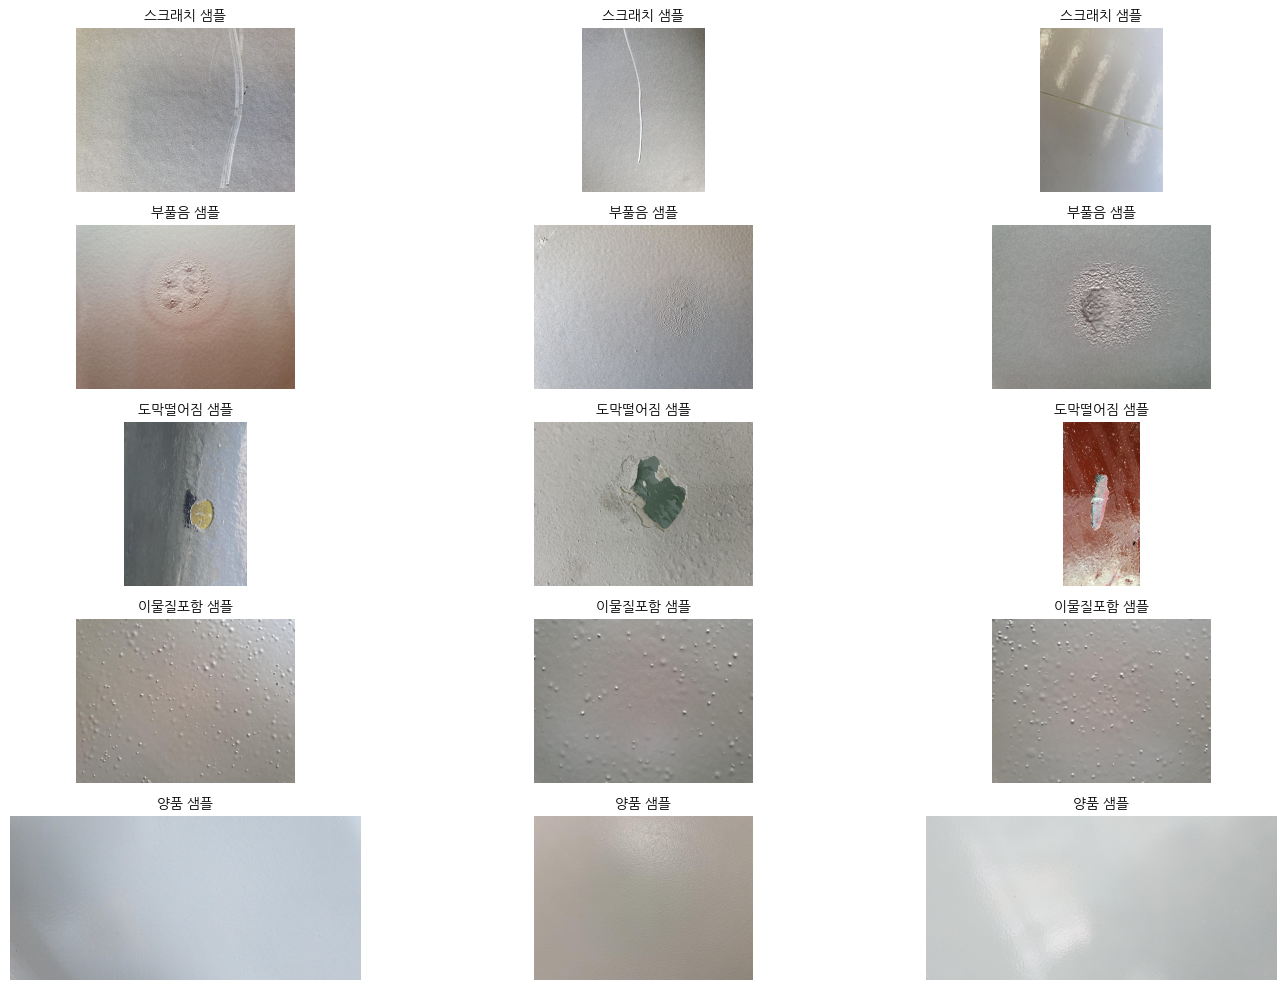

In [8]:
# 시각화 설정
plt.figure(figsize=(15, 10))  # 그래프 전체 크기 설정
num_samples = 3  # 각 클래스에서 보여줄 이미지 개수

# 각 라벨(클래스)별로 이미지 시각화
for i, (label, paths) in enumerate(label_to_paths.items()):
    # 현재 라벨에 해당하는 이미지 경로들에서 num_samples 개수만큼 무작위로 선택
    random_paths = random.sample(paths, min(num_samples, len(paths)))

    # 선택된 이미지를 하나씩 서브플롯(subplot)에 그리기
    for j, img_path in enumerate(random_paths):
        # subplot 위치 지정 (총 라벨 수, 각 라벨당 이미지 수, 현재 위치)
        ax = plt.subplot(len(label_to_paths), num_samples, i * num_samples + j + 1)
        
        # 이미지 열기 및 표시
        img = Image.open(img_path)
        plt.imshow(img)
        
        # 제목 설정 및 축 제거
        plt.title(f"{label} 샘플", fontsize=10)
        plt.axis("off")

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

1. 라벨링 오류: 잘못 분류된 이미지가 있는지 확인 필요.
:샘플로 통찰력 얻기, 그냥 전반적인 특성이랑 심각한 라벨링 오류가 있는지만 확인
> 학습 후 오류 분석 

2. 데이터 특성: 특정 패턴이 반복되는지 확인 필요
> 데이터 증강 기술 이용 필요: 회전 및 뒤집기, 색상 왜곡, 노이즈 추가

3. 배경이나 조명이 너무 다양해서 학습에 방해가 될 만한 요소는 없는지 확인 필요.
> 데이터 증강 기술 이용 필요: 밝기/대비 조절, 랜덤 크롭, 랜덤 이레이징 

--------------------------
'이물질 포함'이나 '부풀음' 클래스의 반복적인 패턴,
다양한 배경, 조명 문제가 보임
> 데이터 증강 기술 이용 필요! 

## 통합 전처리 파이프라인 구축 

:코드가 깔끔해질 수 있게 모든 전처리 과정을 하나로 묶자.

In [10]:
import torchvision.transforms as transforms

# ImageNet 데이터셋의 평균과 표준편차 (딥러닝에서 일반적으로 사용)
# 이 값은 모델의 학습 효율을 높여줍니다.
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# 1. 학습용 데이터 전처리 파이프라인 (Data Augmentation 포함)
train_transform = transforms.Compose([
    # 이미지 크기 통일 (다양한 크기 문제 해결)
    transforms.Resize(IMG_SIZE),
    
    # 조명/배경 문제, 과적합을 막기 위한 데이터 증강
    transforms.RandomHorizontalFlip(),  # 이미지를 무작위로 좌우 반전
    transforms.RandomVerticalFlip(),    # 이미지를 무작위로 상하 반전
    transforms.RandomRotation(30),       # 이미지를 -30도 ~ +30도 사이에서 무작위 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 밝기, 대비 등 무작위 조절
    
    # 이미지를 PyTorch 텐서로 변환 (0-255 -> 0-1)
    transforms.ToTensor(),
    
    # 픽셀 값 정규화
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# 2. 검증/테스트용 데이터 전처리 파이프라인 (Data Augmentation 없음)
val_transform = transforms.Compose([
    # 이미지 크기 통일
    transforms.Resize(IMG_SIZE),
    
    # 이미지를 PyTorch 텐서로 변환
    transforms.ToTensor(),
    
    # 픽셀 값 정규화
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

## 전략적인 데이터 증강
: 데이터 불균형과 배경/조명 문제 해결을 위함.

In [12]:
# 1. 다수 클래스 ('양품')를 위한 전처리
# 증강을 최소화하여 데이터가 과하게 변형되는 것을 방지
majority_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# 2. 소수 클래스를 위한 전처리 (더 공격적인 증강 적용)
minority_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),  # 좌우 반전
    transforms.RandomVerticalFlip(),    # 상하 반전
    transforms.RandomRotation(30),      # 무작위 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 조명, 색상 변화
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])


# 2. X, y 리스트 초기화
X = [] # 이미지 데이터를 저장할 리스트
y = [] # 라벨을 저장할 리스트

# 3. 이미지를 로드하고 전처리하여 리스트에 추가
for folder, label in folder_to_label.items():
    d = ROOT / folder
    for p in d.rglob("*"):
        if p.suffix.lower() in IMG_EXTS:
            try:
                img = Image.open(p).convert("RGB") # 이미지를 RGB로 로드
                
                # 라벨에 따라 다른 파이프라인 적용
                if label == "양품":
                    img_transformed = majority_transform(img)
                else:
                    img_transformed = minority_transform(img)
                
                # 변환된 이미지를 X 리스트에 추가
                X.append(img_transformed)
                # 라벨을 y 리스트에 추가
                y.append(label)
                
            except IOError:
                print(f"이미지를 여는 데 실패했습니다: {p}")
                continue

# X 리스트에 데이터가 PyTorch 텐서로 저장됩니다.
print(f"X 리스트에 저장된 이미지 데이터 개수: {len(X)}")
print(f"y 리스트에 저장된 라벨 개수: {len(y)}")
print("데이터 로딩 및 전처리 완료!")

X 리스트에 저장된 이미지 데이터 개수: 1200
y 리스트에 저장된 라벨 개수: 1200
데이터 로딩 및 전처리 완료!


# 데이터 분할

In [13]:
# 이전에 만든 X(이미지 데이터)와 y(라벨) 리스트가 있다고 가정
# X는 리스트 형태이므로 배열로 변환
X = np.array(X)
y = np.array(y)

# 1. 학습(Train) & 테스트(Test) 세트로 먼저 분할
# test_size=0.2는 전체 데이터의 20%를 테스트 세트로 사용하겠다는 의미
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 학습 세트를 다시 학습(Train) & 검증(Validation) 세트로 분할
# test_size=0.25는 남은 학습 데이터(80%)의 25%이므로, 전체 데이터의 20%가 검증 세트가 됨
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# 각 세트의 데이터 개수 확인
print("="*30)
print(f"학습 세트 크기: {X_train.shape[0]}개")
print(f"검증 세트 크기: {X_val.shape[0]}개")
print(f"테스트 세트 크기: {X_test.shape[0]}개")
print("="*30)

학습 세트 크기: 720개
검증 세트 크기: 240개
테스트 세트 크기: 240개


## 모델 학습

모델은 각자 자유롭게 구성할 수 있으며, 올바른 형식으로 `submission.csv`를 작성한다면 다양한 모델이 허용됩니다.

아래는 이해를 돕기 위한 예시 코드로, 간단한 로지스틱 회귀 모델을 사용합니다.

In [9]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

NameError: name 'X' is not defined

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1_macro_all = f1_score(y_test, y_pred, average="macro")

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1_macro_all:.4f}")

## 모델 평가 및 결과 저장

분류 모델을 평가하기 위한 지표는 다양하게 있으며, 저희는 그 중에서 **F1 Score**를 사용합니다.

여러분들이 작성하신 모델의 성능을 평가하기 위해서는, 지시사항에서 명시한 대로 **테스트 데이터**를 불러와서 예측을 수행하고, 그 결과를 반드시 `submission.csv` 파일에 기록하여 제출해야 합니다.

`submission.csv` 파일은 채점을 위한 코드입니다. index로는 테스트 데이터의 파일 이름들을, "label"열에는 해당 이미지 파일의 손상 종류를 저장해야 합니다. 아래와 같은 형태의 데이터프레임을 만든 뒤 `submission.csv` 파일로 저장해야 합니다.
* 아래 데이터프레임은 예시입니다.
   
|      | label |
| --------- | ----- |
| 00001.jpg | 양품    |
| 00002.jpg | 스크래치    |
| 00003.jpg | 양품    |
| 00004.jpg | 도막떨어짐    |
| 00005.jpg | 양품    |

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

In [ ]:
ROOT = Path("/mnt/elice/dataset")
SUBMIT_DIR = ROOT / "제출용 데이터"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
IMG_SIZE = (128, 128)

In [ ]:
filenames, labels = [], []
for p in SUBMIT_DIR.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        im = Image.open(p).convert("L").resize(IMG_SIZE)
        x = (np.array(im, dtype=np.float32) / 255.0).ravel().reshape(1, -1)
        y_pred = clf.predict(x)
        label_ko = le.inverse_transform(y_pred)[0]  # 한글 라벨 복원
        filenames.append(p.name)  # 인덱스는 파일명(문자열)
        labels.append(label_ko)

In [ ]:
# 제출을 위한 데이터프레임 만들기
df_submit = pd.DataFrame({"label": labels}, index=filenames)
df_submit = df_submit.sort_index() 
df_submit.to_csv("./submission.csv", encoding="utf-8")  # 현재 작업 디렉토리에 저장

df_submit.head()

### 제출

`submission.csv` 파일이 제대로 생성됐다면, 우측 상단의 제출 버튼을 눌러 `submission.csv` 파일을 제출하고 리더보드에서 점수를 확인하세요.

- 팀당 제출 가능 횟수는 **1일 20회** 입니다. 팀 내 모든 구성원이 제출 가능하나 팀 제출 횟수는 팀 단위로 합산됩니다.
- 최종 채점 기준: Private score 50% + Public score 50%
- 리더보드에는 **마지막으로 제출한 결과**의 Public 점수가 공개됩니다.
- 최종 채점에는 마지막으로 제출된 결과로 평가됩니다.

## 경진대회 종료 전 제출을 희망하는 코드와 결과물로 마지막 제출을 수행하세요.
## 반드시 마지막 제출된 프로젝트의 전체 파일을 압축하여 별도의 제출 공간에 제출하세요.

다음 파일들을 압축하여 별도의 제출공간에 제출해야 합니다.
- `code.ipynb`: 전체 프로젝트 진행 파일
- `submission.csv`: 예측 결과 파일
- 외부 데이터 사용 시: 원본 데이터 파일(혹은 데이터 다운로드 코드)
    - 외부 데이터에 대한 전처리 과정은 프로젝트 코드 내에 포함되어야 함
- 기타 프로젝트 실행에 필요한 모든 파일